In [3]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 2.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

### Our Goal is to deploy a model in sagemaker to predict sucess of an offer ###

# 01. Data gathering and cleaning 

In [6]:
# list all files in the StarterFiles directory
print(os.listdir('StarterFiles'))

['portfolio.json', 'pic2.png', 'transcript.json', 'Starbucks_Capstone_notebook.ipynb', 'Starbucks_Capstone_notebook-zh.ipynb', 'profile.json', 'pic1.png']


## 1.1. Portfolio
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [7]:
# reading 'portfolio.json' file into a pandas dataframe
portfolio_ = pd.read_json('StarterFiles/portfolio.json'  , orient='records', lines=True)
portfolio_.head(3)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [8]:
portfolio_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [9]:
# Data preprocessing

# one-hot encoding channels column
portfolio = portfolio_.copy()
portfolio['channels'] = portfolio['channels'].apply(lambda x: ','.join(map(str, x)))
portfolio = portfolio.join(portfolio['channels'].str.get_dummies(','))
portfolio.drop('channels', axis=1, inplace=True)

# one-hot encoding offer_type column
portfolio = portfolio.join(pd.get_dummies(portfolio['offer_type'])) 
portfolio.drop('offer_type', axis=1, inplace=True)

#drop email column since it it contains no useful information
portfolio.drop('email', axis=1, inplace=True)

#rename id column to offer_id, reward to offer_reward and duration to offer_duration
portfolio.rename(columns={'id':'offer_id', 'reward':'offer_reward', 'duration':'offer_duration'}, inplace=True)
portfolio

,offer_reward,difficulty,offer_duration,offer_id,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,0,1,0,1,0


## 1.2. Profile
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [10]:
# reading 'profile.json' file into a pandas dataframe
profile_ = pd.read_json('StarterFiles/profile.json'      , orient='records', lines=True)
profile_.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [11]:
profile_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


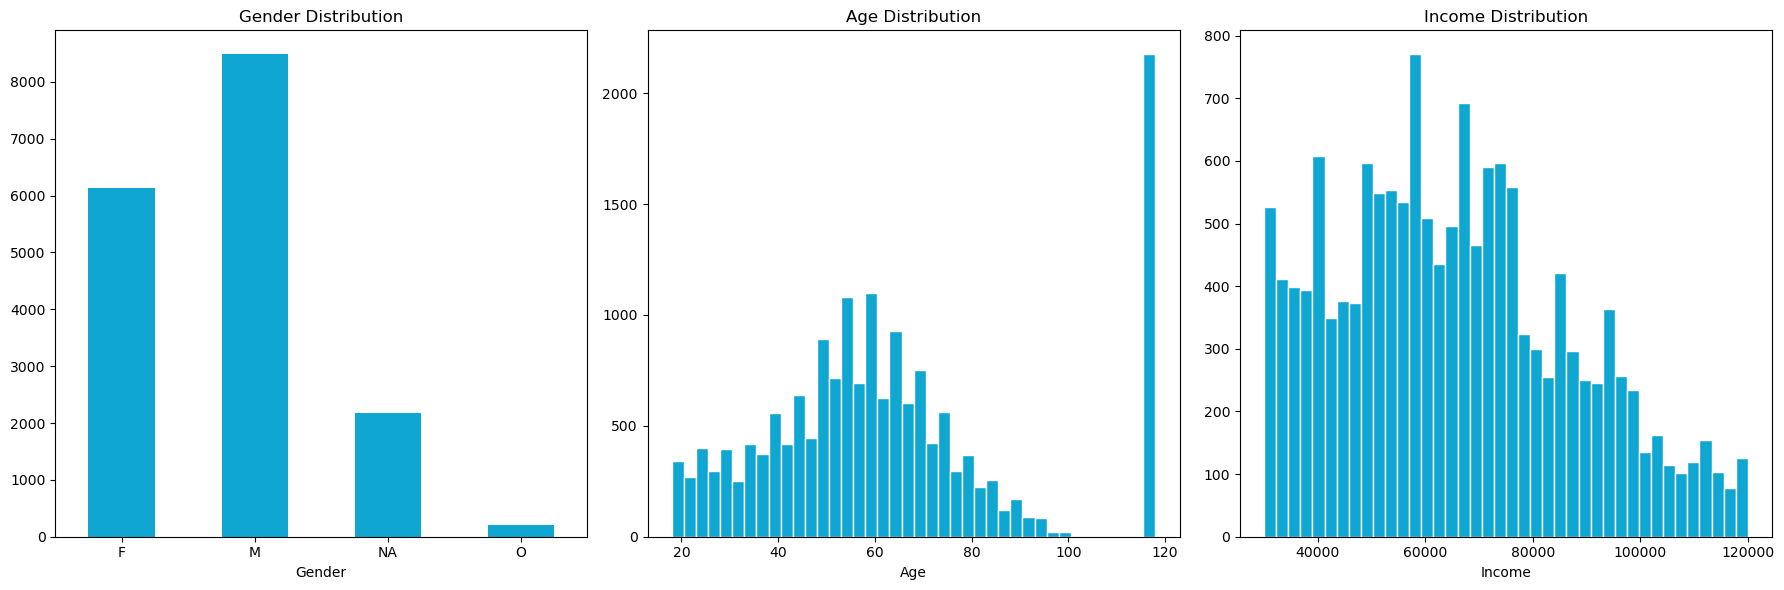

In [12]:
# Creating a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the distribution of gender column
profile_.fillna('NA').groupby('gender').count()['id'].plot(kind='bar', color='#0fa7d1', rot=0, ax=axes[0])
axes[0].set_title("Gender Distribution")
axes[0].set_xlabel("Gender")

# Plotting the age distribution of customers
profile_.age.hist(bins=40, color='#0fa7d1', grid=False, edgecolor='white', ax=axes[1])
axes[1].set_title("Age Distribution")
axes[1].set_xlabel("Age")

# Plotting the income distribution of customers
profile_.income.hist(bins=40, color='#0fa7d1', grid=False, edgecolor='white', ax=axes[2])
axes[2].set_title("Income Distribution")
axes[2].set_xlabel("Income")

# Adjusting spacing between subplots
plt.tight_layout()

# Displaying the figure
plt.show()


In [13]:
# Since there is incomplete data over the gender and some a sinilar amout of age outliers, let's veryfy if they are the same customers
df_temp_outliers = profile_[profile_.isnull().any(axis=1)].fillna('NA')
pd.crosstab(df_temp_outliers['age'], df_temp_outliers['gender'])

gender,NA
age,
118,2175


In [14]:
# Data preprocessing

profile = profile_.copy()
# Since the age outliers and missing age values are the same customers, we lets identify them

# identify the age outliers
profile['imcomplete_data'] = profile['gender'].isnull()

#rename id column to customer_id, became_member_on to became_member_date and income to customer_income
profile.rename(columns={'id':'customer_id', 'became_member_on':'became_member_date', 'income':'customer_income'}, inplace=True)

# adjust became_member_date from string in format YYYYMMDD to datetime
profile['became_member_date'] = pd.to_datetime(profile['became_member_date'], format='%Y%m%d')

# create a new column with the number of days since the customer became a member
profile['memberdays'] = (datetime.datetime.today() - profile['became_member_date']).dt.days

# one hot encoding gender column
profile['gender_M'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)
profile['gender_F'] = profile['gender'].apply(lambda x: 1 if x == 'F' else 0)
profile['gender_0'] = profile['gender'].apply(lambda x: 1 if x == '0' else 0)


profile.head(3)

,gender,age,customer_id,became_member_date,customer_income,imcomplete_data,memberdays,gender_M,gender_F,gender_0
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,True,2293,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,False,2140,0,1,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,True,1778,0,0,0


## 1.3. Transcript 
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [16]:
# reading 'transcript.json' file into a pandas dataframe
transcript_ = pd.read_json('StarterFiles/transcript.json', orient='records', lines=True)
transcript_.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
transcript_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript_.query('event == "offer completed"').head(3)

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0


Text(0.5, 1.0, 'Quantity of events by type')

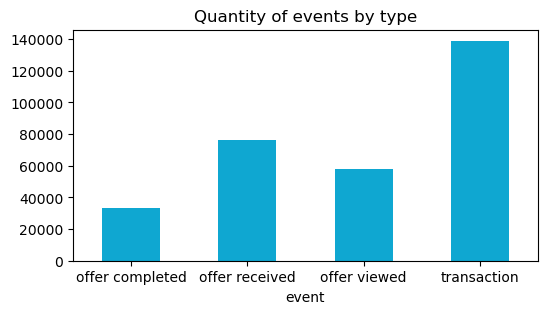

In [19]:
# quantity of events by type
transcript_.groupby('event').count()['person'].plot(kind = 'bar', figsize = (6, 3), color = '#0fa7d1', rot = 0)
plt.title('Quantity of events by type')

In [20]:
# Data preprocessing
transcript = transcript_.copy()
#rename person column to customer_id
transcript.rename(columns={'person':'customer_id'}, inplace=True)

transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id')  if x.get('offer id') != None else x.get('offer_id'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))
# transcript.drop('value', axis=1, inplace=True)

# one-hot encoding event column with a for loop
for event in transcript['event'].drop_duplicates().reset_index(drop=True):
    try:
        transcript[event.split(' ')[1]] = transcript['event'].apply(lambda x: 1 if x == event else 0)
    except:
        transcript[event.split(' ')[0]] = transcript['event'].apply(lambda x: 1 if x == event else 0)

transcript.query('event == "offer completed"').head(3)

,customer_id,event,value,time,offer_id,amount,received,viewed,transaction,completed
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,0,0,1
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,0,0,1
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,0,1


In [21]:
# https://towardsdatascience.com/starbucks-capstone-challenge-35e3b8c6b328
# https://medium.com/swlh/starbucks-capstone-challenge-350575a03f9a


In [22]:
#plotting the distribution of the amount column

# 02. Buiding offer dataset

<AxesSubplot:>

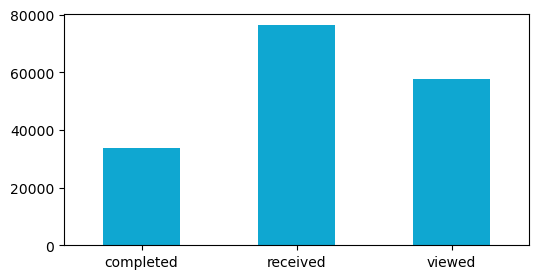

In [24]:
transcript[['completed', 'received', 'viewed']].sum().plot(kind='bar', figsize=(6, 3), color='#0fa7d1', rot=0)

In [25]:
offers = transcript.copy().groupby(['customer_id', 'offer_id']).sum()[[ 'viewed',  'received', 'completed', 'transaction']].reset_index().reset_index().sample(frac=1).reset_index(drop=True)
offers['percent_completed'] = offers['completed'] / offers['received']

In [26]:
offers.query('completed <= received').count() / offers.count()

index                1.0
customer_id          1.0
offer_id             1.0
viewed               1.0
received             1.0
completed            1.0
transaction          1.0
percent_completed    1.0
dtype: float64

In [27]:
#joined df
df_ = offers.merge(portfolio, on='offer_id', how='inner').merge(profile, on='customer_id', how='inner')

df_['offer_completed'] = df_['percent_completed'].apply(lambda x: 1 if x > 0.5 else 0)
df_['offer_recieved']  = df_['received'].apply(lambda x: 1 if x > 0 else 0)
df_['transaction_made'] = df_['transaction'].apply(lambda x: 1 if x > 0 else 0)

df_ =df_.query('offer_recieved == 1')

df_ = df_[df_['imcomplete_data'] == False]
df_.drop(['imcomplete_data', 'became_member_date','gender'], axis=1, inplace=True)
df_.drop(['gender_0'], axis=1, inplace=True)
df_.drop(['customer_id', 'offer_id'], axis=1, inplace=True)
df_.drop(['index','viewed','received','completed','transaction','percent_completed','transaction_made','offer_recieved','gender_F'], axis=1, inplace=True)

df_.shape

(55222, 14)

In [28]:
df_

,offer_reward,difficulty,offer_duration,mobile,social,web,bogo,discount,informational,age,customer_income,memberdays,gender_M,offer_completed
0,0,0,3,1,1,0,0,0,1,84,52000.0,2428,0,0
1,10,10,5,1,1,1,1,0,0,84,52000.0,2428,0,1
2,2,10,10,1,1,1,0,1,0,84,52000.0,2428,0,1
3,5,5,5,1,1,1,1,0,0,84,52000.0,2428,0,1
4,2,10,7,1,0,1,0,1,0,84,52000.0,2428,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,5,20,10,0,0,1,0,1,0,20,49000.0,2042,0,1
63284,5,20,10,0,0,1,0,1,0,47,48000.0,2073,0,0
63285,5,20,10,0,0,1,0,1,0,22,65000.0,2585,0,1
63286,5,20,10,0,0,1,0,1,0,64,93000.0,2826,0,0


array([[<AxesSubplot:title={'center':'offer_completed'}>]], dtype=object)

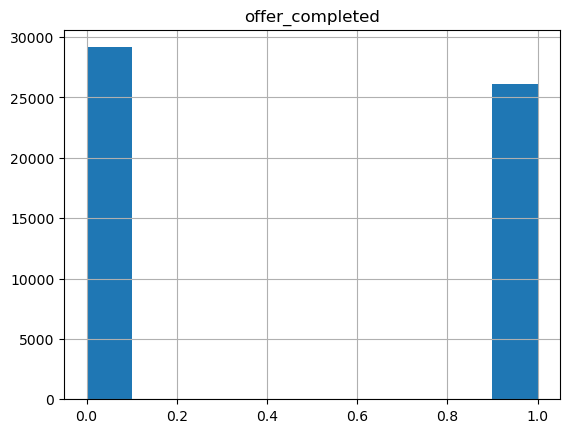

In [29]:
df_[['offer_completed']].hist()

# 3. Testing a ML aproach

In [30]:
# dividing the dataset train, validation and test
from sklearn.model_selection import train_test_split

X = df_.drop('offer_completed', axis=1)
y = df_['offer_completed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_['offer_completed'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [31]:
#  Building the model
# creating a function to train and evaluate the model
def train_evaluate_model(model, X_train, y_train, X_val, y_val):
    # training the model
    model.fit(X_train, y_train)
    
    # predicting the model
    y_pred = model.predict(X_val)

    # evaluating the model
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)

    # printing the metrics
    print('Accuracy: {:.2f}%'.format(accuracy*100))
    print('Precision: {:.2f}%'.format(precision*100))
    print('Recall: {:.2f}%'.format(recall*100))
    print('F1 Score: {:.2f}%'.format(f1*100))
    print('ROC AUC: {:.2f}%'.format(roc_auc*100))

    # plotting the confusion matrix and ROC AUC curve side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, ax=ax1, cmap='Blues', fmt='g')
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['No', 'Yes'])
    ax1.yaxis.set_ticklabels(['No', 'Yes'])

    # ROC Curve
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.plot(fpr, tpr)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')

    # Adjust the spacing between plots
    plt.tight_layout()

    # Show the plots
    plt.show()

Accuracy: 78.28%
Precision: 75.53%
Recall: 79.89%
F1 Score: 77.65%
ROC AUC: 78.37%


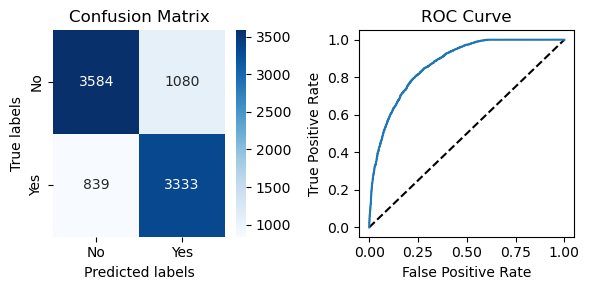

In [32]:
# 03.1. XGBoost Classifier
# training and evaluating the model
xgb = XGBClassifier(random_state=42)
train_evaluate_model(xgb, X_train, y_train, X_val, y_val)


In [34]:
# import classification_report
from sklearn.metrics import classification_report
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      5830
           1       0.75      0.79      0.77      5215

    accuracy                           0.78     11045
   macro avg       0.78      0.78      0.78     11045
weighted avg       0.78      0.78      0.78     11045



# 4. Deploying sagemaker model

In [53]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

In [36]:
X = df_.drop('offer_completed', axis=1)
y = df_['offer_completed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_['offer_completed'])

In [75]:
train_data = pd.concat([y_train,X_train], axis=1)
train_data.to_csv('train_data.csv', index=False,header=False)

test_data = pd.concat([y_test,X_test], axis=1)
test_data.to_csv('test_data.csv', index=False,header=False)

In [76]:
sagemaker_session = sagemaker.Session()
bucket = 'udacity-capstone-bucket-starbucks'

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [77]:
input_train = sagemaker_session.upload_data(path='train_data.csv', bucket=bucket, key_prefix=prefix + '/train')
input_test  = sagemaker_session.upload_data(path='train_data.csv', bucket=bucket, key_prefix=prefix + '/train')

In [78]:
prefix = 'xgboost-example'
input_train = sagemaker_session.upload_data(path='train_data.csv', bucket=bucket, key_prefix=prefix + '/train')
input_test = sagemaker_session.upload_data(path='test_data.csv', bucket=bucket, key_prefix=prefix + '/test')

In [79]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [80]:
role = get_execution_role()

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path=f's3://{bucket}/{prefix}/output',
                                    sagemaker_session=sagemaker_session)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [81]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)

In [82]:
train_data = sagemaker.inputs.TrainingInput(s3_data=input_train, content_type='csv')
test_data = sagemaker.inputs.TrainingInput(s3_data=input_test, content_type='csv')

data_channels = {'train': train_data, 'validation': test_data}

In [83]:
xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: xgboost-2023-05-25-00-57-14-116


2023-05-25 00:57:14 Starting - Starting the training job...
2023-05-25 00:57:30 Starting - Preparing the instances for training.........
2023-05-25 00:58:56 Downloading - Downloading input data...
2023-05-25 00:59:26 Training - Downloading the training image...
2023-05-25 01:00:12 Training - Training image download completed. Training in progress..Arguments: train
[2023-05-25:01:00:21:INFO] Running standalone xgboost training.
[2023-05-25:01:00:21:INFO] File size need to be processed in the node: 2.05mb. Available memory size in the node: 8588.16mb
[2023-05-25:01:00:21:INFO] Determined delimiter of CSV input is ','
[01:00:21] S3DistributionType set as FullyReplicated
[01:00:21] 44177x13 matrix with 574301 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-05-25:01:00:21:INFO] Determined delimiter of CSV input is ','
[01:00:21] S3DistributionType set as FullyReplicated
[01:00:21] 11045x13 matrix with 143585 entries loaded from /opt/ml/input/data/val

In [84]:
model_name = 'xgboost-model'
model = xgb.create_model(name=model_name)

In [85]:
endpoint_name = 'xgboost-endpoint'
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: xgboost-model
INFO:sagemaker:Creating endpoint-config with name xgboost-endpoint
INFO:sagemaker:Creating endpoint with name xgboost-endpoint


----------!

# 5. Testing Endpoint

In [123]:
import json
# Hardcoded data for prediction
hardcoded_data = {
"offer_reward":30.0,
"difficulty":30.0,
"offer_duration":30.0,
"mobile":1.0,
"social":1.0,
"web":1.0,
"bogo":1.0,
"discount":10.0,
"informational":1.0,
"age":58.0,
"customer_income":550000.0,
"memberdays":32981.0,
"gender_M":1.0
}

# Convert the hardcoded data to a list of values
input_data = [list(hardcoded_data.values())]

# Create a low-level SageMaker client
sagemaker_client = boto3.client('sagemaker-runtime')

# Specify the endpoint name
endpoint_name = 'xgboost-endpoint'

# Convert the input data to CSV format
input_data_csv = ','.join([str(val) for val in input_data[0]])

# Make a request to the endpoint
response = sagemaker_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=input_data_csv
)


# Parse the response
prediction = response['Body'].read().decode()
prediction = json.loads(prediction)

if prediction > 0.5:
    print('The offer will likely be completed. (probability: {:.2f}%)'.format(prediction*100))
else:
    print('The offer will not likely be completed. (probability: {:.2f}%)'.format(prediction*100))

The offer will likely be completed. (probability: 82.38%)
